In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from shapely.geometry import Polygon
from tqdm.notebook import tqdm


# Define the root path to the dataset
dataset_root = os.path.join('NIH-NLM-ThinBloodSmearsPf', 'Polygon Set')

print(f"Dataset root set to: {os.path.abspath(dataset_root)}")

Dataset root set to: c:\Users\Polina\Documents\Python_files\AI\Computer_Vision\Malaria_Screening\NIH-NLM-ThinBloodSmearsPf\Polygon Set


# Exploration of data in term of Overlapping of the cells

In [2]:
def process_single_file(txt_path):
    filename = os.path.basename(txt_path)
    patient_id = os.path.basename(os.path.dirname(os.path.dirname(txt_path)))
    
    overlaps_data = []
    polys = []
    ids = []
    
    with open(txt_path, 'r') as f:
        lines = f.readlines()
        
    if len(lines) < 2: 
        return [], 0

    for line in lines[1:]:
        parts = line.strip().split(',')
        if len(parts) < 6: continue
        
        cell_id = parts[0]
        coords = [float(x) for x in parts[5:]]
        pts = list(zip(coords[0::2], coords[1::2]))
        
        if len(pts) < 3: continue
        
        poly = Polygon(pts)
        if not poly.is_valid: poly = poly.buffer(0)
            
        polys.append(poly)
        ids.append(cell_id)
        
    total_cells = len(polys)
        
    num_polys = len(polys)
    for i in range(num_polys):
        for j in range(i + 1, num_polys):
            p1 = polys[i]
            p2 = polys[j]
            
            if p1.intersects(p2):
                intersection_area = p1.intersection(p2).area
                
                if intersection_area > 1.0:
                    min_area = min(p1.area, p2.area)
                    overlap_ratio = intersection_area / min_area
                    
                    overlaps_data.append({
                        'Patient_ID': patient_id,
                        'Image_Name': filename,
                        'Full_Path': txt_path,
                        'Cell_1': ids[i],
                        'Cell_2': ids[j],
                        'Overlap_Ratio': overlap_ratio
                    })
                    
    return overlaps_data, total_cells

In [3]:
search_path = os.path.join(dataset_root, "**", "GT", "*.txt")
txt_files = glob.glob(search_path, recursive=True)

all_overlaps = []
total_cells_global = 0

print(f"{len(txt_files)} files ")

for txt_file in tqdm(txt_files, desc="Processing"):
    file_overlaps, count_cells = process_single_file(txt_file)
    
    all_overlaps.extend(file_overlaps)
    total_cells_global += count_cells

165 files 


Processing:   0%|          | 0/165 [00:00<?, ?it/s]

In [6]:
df_overlaps = pd.DataFrame(all_overlaps)

if df_overlaps.empty:
    print("There is no overlapping")
else:
    cols_to_show = ['Patient_ID', 'Image_Name', 'Cell_1', 'Cell_2', 'Overlap_Ratio']
    df_overlaps = df_overlaps.sort_values(by='Overlap_Ratio', ascending=False)
    
    num_bad_pairs = len(df_overlaps)
    percent_bad = (num_bad_pairs * 2 / total_cells_global) * 100
    
    print(f"Total Cells Processed: {total_cells_global}")
    print(f"Total Overlapping Pairs: {num_bad_pairs}, {percent_bad:.2f}% of total data")
    print(f"Average Overlap: {df_overlaps['Overlap_Ratio'].mean()*100:.1f}%")

Total Cells Processed: 34264
Total Overlapping Pairs: 5595, 32.66% of total data
Average Overlap: 6.7%


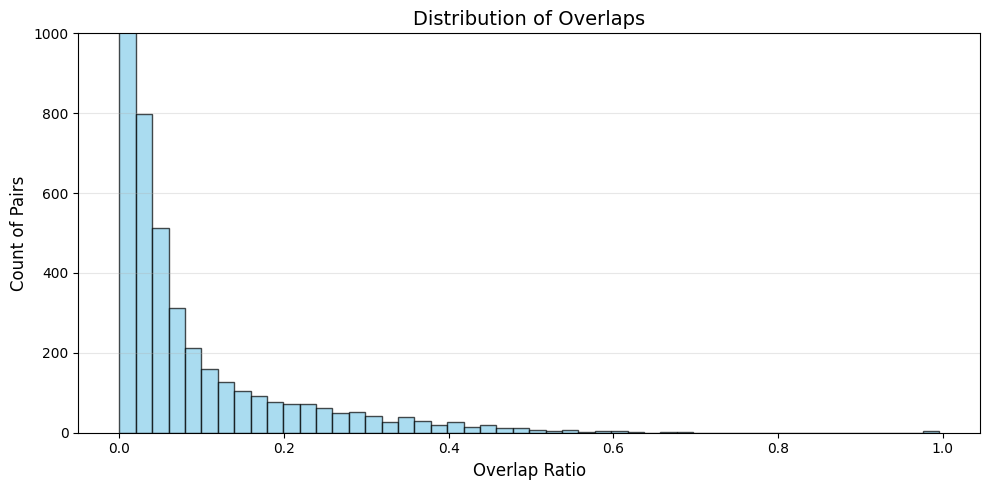

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(df_overlaps['Overlap_Ratio'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Overlaps', fontsize=14)
plt.xlabel('Overlap Ratio', fontsize=12)
plt.ylabel('Count of Pairs', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()



In [7]:
def plot_overlap_on_image(row):
    txt_path = row['Full_Path']
    id1, id2 = row['Cell_1'], row['Cell_2']
    
    base_folder, filename = os.path.split(txt_path)
    patient_folder = os.path.dirname(base_folder) # Parent of GT
    
    img_folder = os.path.join(patient_folder, 'Img')
    img_filename = filename.replace('.txt', '.jpg')
    img_path = os.path.join(img_folder, img_filename)
    
    if not os.path.exists(img_path):
        print(f"Image not found at: {img_path}")
        return

    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image file")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    polys = {}
    with open(txt_path, 'r') as f:
        lines = f.readlines()
        for line in lines[1:]:
            parts = line.strip().split(',')
            if len(parts) < 6: continue
            cid = parts[0]
            coords = [float(x) for x in parts[5:]]
            polys[cid] = list(zip(coords[0::2], coords[1::2]))

    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.imshow(image)
    
    for cid, pts in polys.items():
        poly = plt.Polygon(pts, fill=False, edgecolor='white', linewidth=0.5, alpha=0.4)
        ax.add_patch(poly)
        
    if id1 in polys:
        p1 = plt.Polygon(polys[id1], fill=False, alpha=0.3, 
                         edgecolor='red', linewidth=2, label=f'Cell {id1}')
        ax.add_patch(p1)
        
    if id2 in polys:
        p2 = plt.Polygon(polys[id2], fill=False, alpha=0.3, 
                         edgecolor='blue', linewidth=2, label=f'Cell {id2}')
        ax.add_patch(p2)
        
    conflict_pts = polys.get(id1, []) + polys.get(id2, [])
    if conflict_pts:
        pts_arr = np.array(conflict_pts)
        min_x, max_x = pts_arr[:, 0].min(), pts_arr[:, 0].max()
        min_y, max_y = pts_arr[:, 1].min(), pts_arr[:, 1].max()
        
        margin = 150
        ax.set_xlim(min_x - margin, max_x + margin)
        ax.set_ylim(max_y + margin, min_y - margin)
        
    plt.title(f"Overlap: {row['Overlap_Ratio']*100:.1f}% \n {row['Patient_ID']}, {row['Image_Name']}")
    plt.legend()
    plt.axis('on')
    plt.show()

Worst Overlap


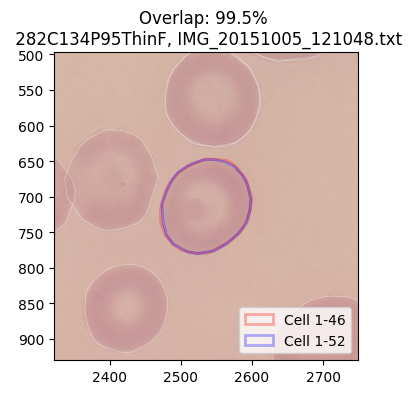

In [35]:
print("Worst Overlap")
cases = df_overlaps.head(1)

for idx, row in cases.iterrows():
    plot_overlap_on_image(row)

Worst Overlap without repetition of polygons, < 0.8


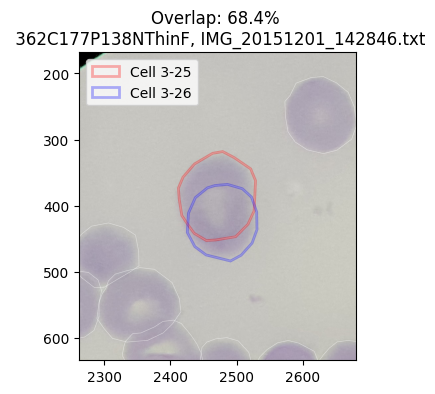

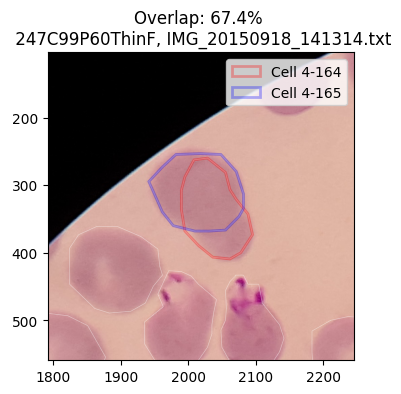

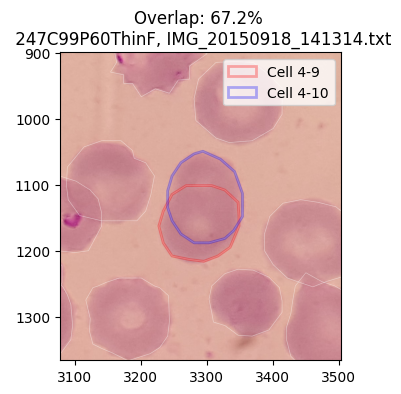

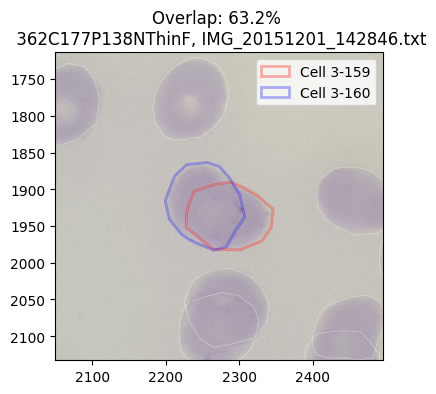

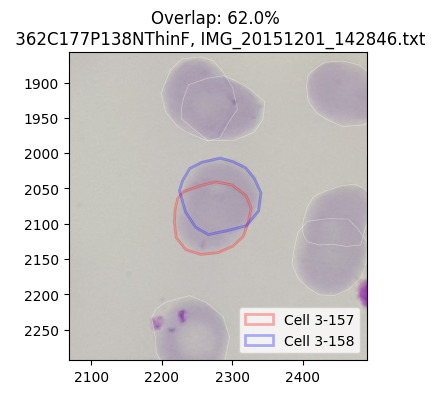

In [38]:
print("Worst Overlap without repetition of polygons, < 0.8")
cases = df_overlaps[df_overlaps['Overlap_Ratio']< 0.8].head(5)

for idx, row in cases.iterrows():
    plot_overlap_on_image(row)

Overlap < 0.4


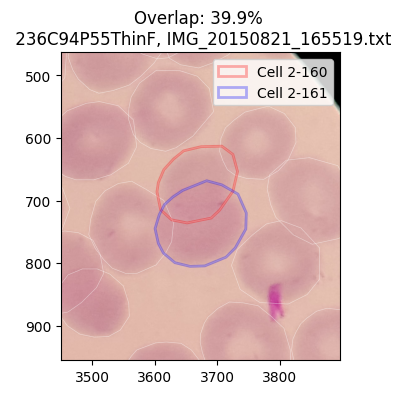

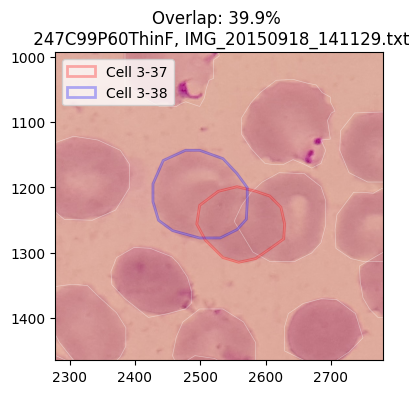

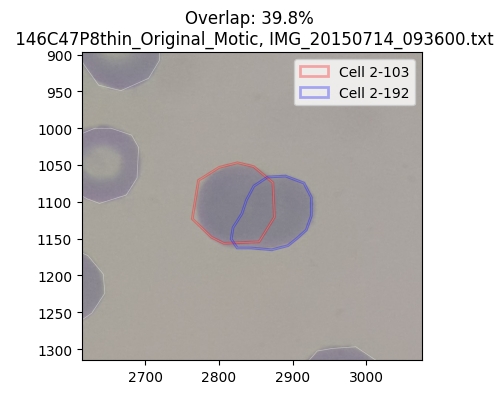

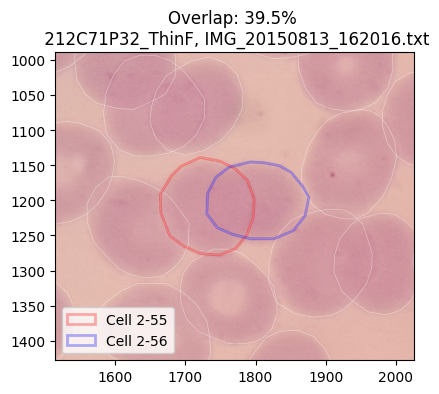

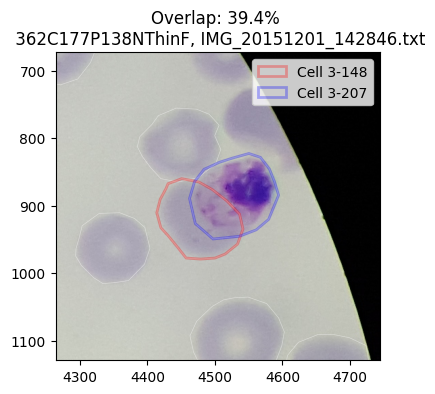

In [8]:
print("Overlap < 0.4")
cases = df_overlaps[df_overlaps['Overlap_Ratio']< 0.4].head(5)

for idx, row in cases.iterrows():
    plot_overlap_on_image(row)

Overlap < 0.2


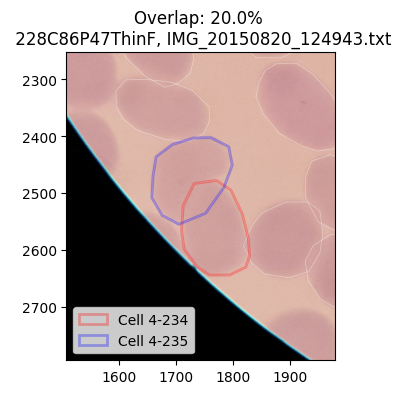

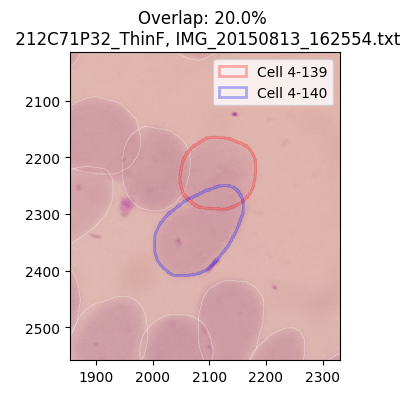

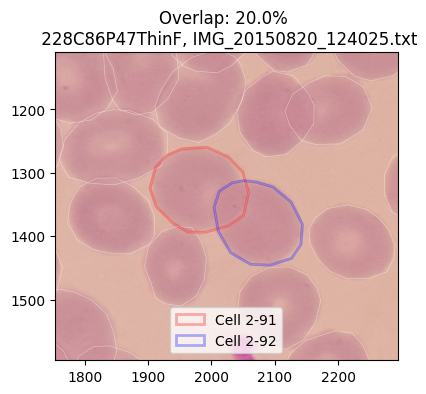

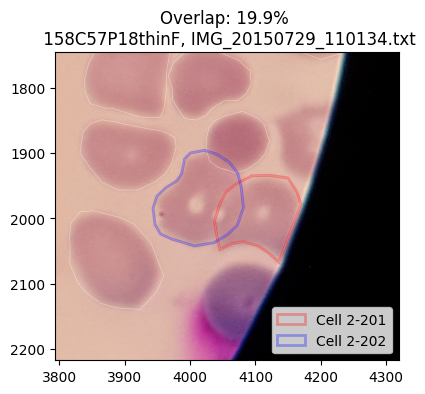

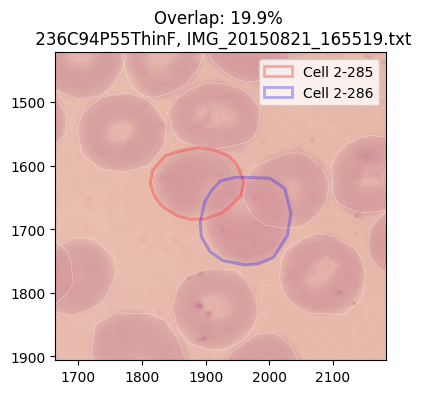

In [39]:
print("Overlap < 0.2")
cases = df_overlaps[df_overlaps['Overlap_Ratio']< 0.2].head(5)

for idx, row in cases.iterrows():
    plot_overlap_on_image(row)

# Binary Masks generation

In [1]:
import generate_masks

generate_masks.main()

Found annotation files: 165


Generating masks:   0%|          | 0/165 [00:00<?, ?it/s]


Masks saved
